In [16]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# GMMで使うライブラリ
from scipy.stats import multivariate_normal

# scipy から 多次元スチューデントのt分布の multivariate_t という関数が読めるか確認してください。
# バージョンにより廃止されているそうです。エラーが出る場合は、コメントアウトしてください。
from scipy.stats import multivariate_t

In [19]:
# 上記でエラーがでた場合は、multivariate_t.pdf の代わりに、以下の gammaln を使った自作関数、multivariate_t_pdf を使ってください。
# 参考：https://gregorygundersen.com/blog/2020/01/20/multivariate-t/
from   scipy.special import gammaln

def multivariate_t_pdf(x, loc, shape, df):
    dim = loc.size

    vals, vecs = np.linalg.eigh(shape)
    logdet     = np.log(vals).sum()
    valsinv    = np.array([1./v for v in vals])
    U          = vecs * np.sqrt(valsinv)
    dev        = x - loc
    maha       = np.square(np.dot(dev, U)).sum(axis=-1)

    t = 0.5 * (df + dim)
    A = gammaln(t)
    B = gammaln(0.5 * df)
    C = dim/2. * np.log(df * np.pi)
    D = 0.5 * logdet
    E = -t * np.log(1 + (1./df) * maha)

    return np.exp(A - B - C - D + E)

# GMMのパラメータの変分推論による推定

教科書 4.4.4節を参考に、人工的に生成したデータを用いて、GMMのパラメータを崩壊型ギブスサンプリングにより推定します。

コード元：https://www.anarchive-beta.com/entry/2021/05/16/182644

## 真のモデルのパラメータとモデルから生成した観測データををJSONから読み込み

note12-2と同じです。

In [20]:
# note12-1で保存したパラメータを利用する
import json
with open(output_dir + 'note12-1_output.json') as json_file:
   json_data = json.load(json_file) # JSONファイルを辞書型の変数として読み出す

#print (json_data)

# 個別の変数に戻す
D = json_data['D'] # 次元数:(固定)
K = json_data['K'] # クラスタ数
N = json_data['N']

# ndarray 型に戻し、行列などに reshape で戻す
# 真のモデル関連
mu_truth_kd = np.array(json_data['mu_truth_kd']) # K個の真の平均を指定
sigma2_truth_kdd = np.array(json_data['sigma2_truth_kdd']).reshape(K,D,D) # K個の真の共分散行列を指定
pi_truth_k = np.array(json_data['pi_truth_k']) # 真の混合比率を指定（各値は0以上で、合計は1になること）
# 真のモデルから生成した観測データ関連
s_truth_nk = np.array(json_data['s_truth_nk']).reshape(N,K) # 潜在変数
s_truth_n = np.array(json_data['s_truth_n']).reshape(N,) # クラスタ番号
x_nd = np.array(json_data['x_nd']).reshape(N,D) # ランダムサンプリングより得た観測データ

# 作図データを作成作成
# 作図用のx軸のxの値を作成 (K個のクラスタそれぞれで平均値±3標準偏差を計算して、その最小値から最大値までを範囲とする)
x_1_line = np.linspace(
    np.min(mu_truth_kd[:, 0] - 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    np.max(mu_truth_kd[:, 0] + 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    num=300
)

# 作図用のy軸のxの値を作成 (K個のクラスタそれぞれで平均値±3標準偏差を計算して、その最小値から最大値までを範囲とする)
x_2_line = np.linspace(
    np.min(mu_truth_kd[:, 1] - 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    np.max(mu_truth_kd[:, 1] + 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    num=300
)

# 確率密度を等高線図にする際に格子状の点(2軸の全ての値が直交する点)を渡す必要があるため、作図用の格子状の点を作成する。する。
# x_1_lineとx_2_lineの要素の全ての組み合わせを持つような2次元配列に変換している。
x_1_grid, x_2_grid = np.meshgrid(x_1_line, x_2_line)

# x_1_grid, x_2_gridの要素を列として持つ2次元配列を作成をし、作図用のxの点とする。
x_point = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存：
# 計算結果の確率密度は1次元配列になり、作図時にx_1_grid, x_2_gridと同じ形状にする必要があるため、形状をx_dimとして保存
x_dim = x_1_grid.shape

# 観測モデルの確率密度を計算しなおしておく
# K個のパラメータmu_truth_kd, sigmga2_truth_ddkを使って、x_point_matの点ごとに、次の混合ガウス分布の式で確率密度を計算
true_model = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(x=x_point, mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k])
    
    # K個の分布の加重平均を計算
    true_model += pi_truth_k[k] * tmp_density

# 確認
print(true_model[:5])


[9.06768334e-13 1.07345258e-12 1.27033352e-12 1.50260830e-12
 1.77630256e-12]


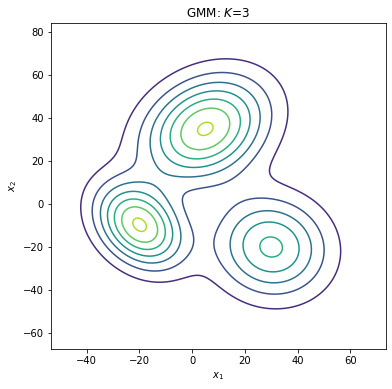

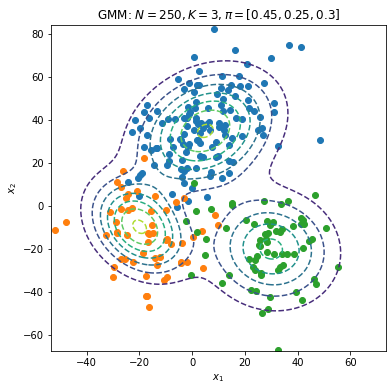

In [21]:
# 観測モデルを作図
plt.figure(figsize=(6, 6))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim)) # 真の分布
plt.title('GMM: $K$=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

# モデルに観測データの散布図を重ねて表示
plt.figure(figsize=(6, 6))
for k in range(K):
    k_idx, = np.where(s_truth_n == k) # クラスタkのデータのインデック
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # 観測データ
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), linestyles='--') # 真の分布
plt.title('GMM: $N=' + str(N) + ', K=' + str(K) + 
          ', \pi=[' + ', '.join([str(pi) for pi in pi_truth_k]) + ']$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## 観測データから各データのクラスタを推定

### 事前分布を設定

次に、観測モデル(観測データの分布)と潜在変数の分布に対する共役事前分布を設定します。多次元ガウス分布のパラメータに対する事前分布としてガウス・ウィシャート分布、カテゴリ分布のパラメータ
に対する事前分布としてディリクレ分布
を設定します。

(300, 300)
[1.10780663e-05 1.12959859e-05 1.15165400e-05 1.17397162e-05
 1.19655008e-05]


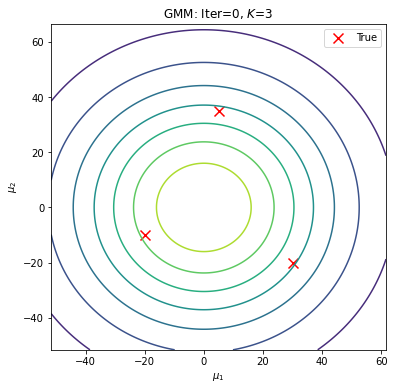

In [22]:
# note12-1と同じなので説明は省略

# muの事前分布のパラメータを指定
beta = 1.0
m_d = np.repeat(0.0, D)

# lambdaの事前分布のパラメータを指定
w_dd = np.identity(D) * 0.0005
nu = D

# piの事前分布のパラメータを指定
alpha_k = np.repeat(2.0, K)

# muの事前分布の標準偏差を計算
sigma_mu_d = np.sqrt(np.linalg.inv(beta * nu * w_dd).diagonal())

# 作図用のx軸のmuの値を作成
mu_0_line = np.linspace(
    np.min(mu_truth_kd[:, 0]) - sigma_mu_d[0], 
    np.max(mu_truth_kd[:, 0]) + sigma_mu_d[0], 
    num=300
)

# 作図用のy軸のmuの値を作成
mu_1_line = np.linspace(
    np.min(mu_truth_kd[:, 1]) - sigma_mu_d[1], 
    np.max(mu_truth_kd[:, 1]) + sigma_mu_d[1], 
    num=300
)

# 作図用の格子状の点を作成
mu_0_grid, mu_1_grid = np.meshgrid(mu_0_line, mu_1_line)

# 作図用のmuの点を作成
mu_point = np.stack([mu_0_grid.flatten(), mu_1_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存
mu_dim = mu_0_grid.shape
print(mu_dim)

# muの事前分布を計算
prior_mu_density = multivariate_normal.pdf(x=mu_point, mean=m_d, cov=np.linalg.inv(beta * nu * w_dd))

# 確認
print(prior_mu_density[:5])

# muの事前分布を作図
plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='True', color='red', s=100, marker='x') # 真の平均
plt.contour(mu_0_grid, mu_1_grid, prior_mu_density.reshape(mu_dim)) # 事前分布
plt.title('GMM: Iter=' + str(0) + ', $K$=' + str(K))
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.legend()
plt.show()

## 初期値の設定

潜在変数$S$の近似事後分布$q(S)$の期待値$E_{q(S)}[S]$をランダムに生成して初期値とする。また生成した$E_{q(S)}[S]$を用いて、各パラメータ $\mu, \Lambda, \pi$ の近似事後分布 $q(\mu|\Lambda), q(\Lambda), q(\pi)$ のパラメータ $\hat{m}, \hat{\beta}, \hat{\nu}, \hat{W}, \hat{\alpha}$を計算して初期値とする。 

In [23]:
# 真のクラスタのときと同様に、alpha_k を用いて潜在変数を初期化し、し、s_nkとする
s_nk = np.random.multinomial(n=1, pvals=alpha_k / np.sum(alpha_k), size=N)

print(s_nk[:5])# 確認

[[0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [24]:
# 初期値によるmuの事後分布のパラメータを計算:式(4.99)
# この時点ではN個全てのデータを使って計算しているため、(崩壊型でない)ギブスサンプリング(4.4.2項)の式(4.99)を使う
beta_hat_k = np.sum(s_nk, axis=0) + beta
m_hat_kd = (np.dot(s_nk.T, x_nd) + beta * m_d) / beta_hat_k.reshape(K, 1)

# 確認
print(beta_hat_k)
print(m_hat_kd)

[88. 85. 80.]
[[ 3.47745457  9.25477949]
 [ 5.43447526 11.22372805]
 [ 8.54222024 10.44662869]]


In [25]:
# 初期値によるlambdaの事後分布のパラメータを計算:式(4.103)
w_hat_kdd = np.zeros((K, D, D))
for k in range(K):
    inv_w_dd = np.dot(s_nk[:, k] * x_nd.T, x_nd)
    inv_w_dd += beta * np.dot(m_d.reshape((D, 1)), m_d.reshape((1, D)))
    inv_w_dd -= beta_hat_k[k] * np.dot(m_hat_kd[k].reshape((D, 1)), m_hat_kd[k].reshape((1, D)))
    inv_w_dd += np.linalg.inv(w_dd)
    w_hat_kdd[k] = np.linalg.inv(inv_w_dd) # パラメータ \hat{W}

nu_hat_k = np.sum(s_nk, axis=0) + nu # 自由度

# 確認
print(w_hat_kdd)
print(nu_hat_k)

[[[2.68879216e-05 1.25942893e-06]
  [1.25942893e-06 1.16182352e-05]]

 [[2.92676085e-05 1.34642284e-07]
  [1.34642284e-07 1.06583362e-05]]

 [[2.45058183e-05 2.29539148e-06]
  [2.29539148e-06 1.59546986e-05]]]
[89 86 81]


In [26]:
# 初期値によるpiの事後分布のパラメータを計算:式(4.45)
alpha_hat_k = np.sum(s_nk, axis=0) + alpha_k

# 確認
print(alpha_hat_k)

[89. 86. 81.]


In [27]:
# 得られた超パラメータの初期値を用いて、muの近似事後分布を計算する
posterior_density_kg = np.empty((K, mu_point.shape[0]))
for k in range(K):
    # クラスタkのmuの事後分布を計算
    posterior_density_kg[k] = multivariate_normal.pdf( # K個の多次元ガウス分布
        x=mu_point, 
        mean=m_hat_kd[k], # 平均
        cov=np.linalg.inv(beta_hat_k[k] * nu_hat_k[k] * w_hat_kdd[k]) # 精度行列
    )

# 確認
print(posterior_density_kg[:, :5])

[[8.15135032e-229 8.16685041e-227 7.93889829e-225 7.48766610e-223
  6.85193596e-221]
 [5.15867681e-222 5.29643837e-220 5.27352237e-218 5.09200627e-216
  4.76813271e-214]
 [7.43241761e-238 3.88662519e-236 1.98665388e-234 9.92610229e-233
  4.84777297e-231]]


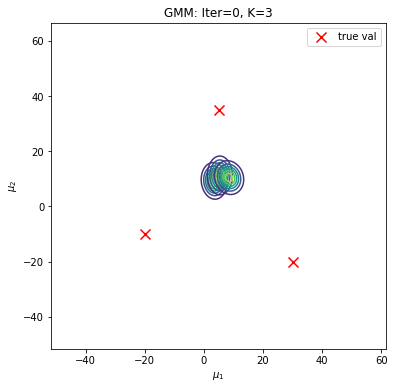

In [28]:
# 初期値によるmuの近似事後分布を作図
plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='true val', 
            color='red', s=100, marker='x') # 真の平均
for k in range(K):
    plt.contour(mu_0_grid, mu_1_grid, posterior_density_kg[k].reshape(mu_dim)) # 近似事後分布

plt.title('GMM: Iter=' + str(0) + ', K=' + str(K))
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.legend()
plt.show()

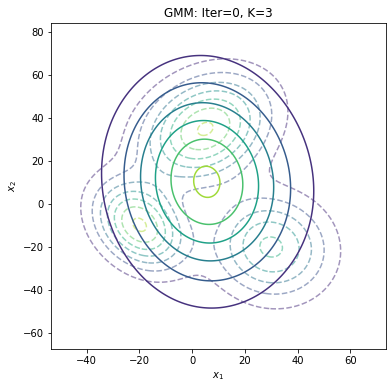

In [29]:
# 初期値から混合分布を計算 (note12-2と同じ）
init_density = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(x=x_point, mean=m_hat_kd[k], cov=np.linalg.inv(nu_hat_k[k] * w_hat_kdd[k]))
    
    # K個の分布の加重平均を計算
    init_density += alpha_hat_k[k] / np.sum(alpha_hat_k) * tmp_density

# 初期値による分布を作図
plt.figure(figsize=(6, 6))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), alpha=0.5, linestyles='dashed') # 真の分布
plt.contour(x_1_grid, x_2_grid, init_density.reshape(x_dim)) # 期待値による分布:(等高線)
plt.title('GMM: Iter=' + str(0) + ', K=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

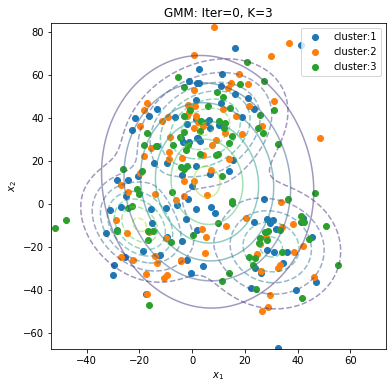

In [30]:
# クラスタ番号を抽出
_, s_n = np.where(s_nk == 1)

# クラスタの散布図を作成
plt.figure(figsize=(6, 6))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), alpha=0.5, linestyles='dashed') # 真の分布
#plt.contour(x_1_grid, x_2_grid, init_density.reshape(x_dim)) # 期待値による分布:(等高線)
plt.contour(x_1_grid, x_2_grid, init_density.reshape(x_dim), alpha=0.5) # 期待値による分布
for k in range(K):
    k_idx, = np.where(s_n == k) # クラスタkのデータのインデックス
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # サンプルしたクラスタ

plt.title('GMM: Iter=' + str(0) + ', K=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## 崩壊型ギブスサンプリング

崩壊型ギブスサンプリングでは、潜在変数 $s_n$ のサンプリングと、各パラメータ $\mu, \Lambda, \pi$ の事後分布のパラメータ（超パラメータ）の更新を交互に行う。

1回の試行ごとに、N個のすべてのデータについて以下を行う
1. 超パラメータの初期値を用いて1番目の潜在変数 $s_1$ の事後分布 $p(s_1|X, S_{\backslash 1})$ を計算し、更新した $S$を用いて超パラメータを更新

2. 更新した超パラメータを用いて $s_2$ の事後分布 $p(s_2|X, S_{\backslash 2})$ を計算し、$S$を用いて超パラメータを更新

In [31]:
# 試行回数を指定
MaxIter = 150

# 途中計算に用いる項の受け皿を作成（スチューデントのt分布の確率密度の変数density_st_kに関して、添字を使って代入するため予め変数を用意しておく）
density_st_k = np.zeros(K)

# 推移の確認用の受け皿を作成
_, s_n = np.where(s_nk == 1) # クラスタ番号を抽出
trace_s_in = [s_n.copy()]
trace_beta_ik = [beta_hat_k.copy()]
trace_m_ikd = [m_hat_kd.copy()]
trace_w_ikdd = [w_hat_kdd.copy()]
trace_nu_ik = [nu_hat_k.copy()]
trace_alpha_ik = [alpha_hat_k.copy()]

# 崩壊型ギブスサンプリング
for i in range(MaxIter):
    for n in range(N):
        
        # n番目のデータの潜在変数を初期化
        s_nk[n] = np.repeat(0, K)
        
        # muの事後分布のパラメータを計算:式(4.128)
        beta_hat_k = np.sum(s_nk, axis=0) + beta
        m_hat_kd = (np.dot(s_nk.T, x_nd) + beta * m_d) / beta_hat_k.reshape(K, 1)
        
        # lambdaの事後分布のパラメータを計算:式(4.128)
        # ただし、n番目のデータを除く処理 (n' /= n 条件)が実装されていない。
        term_m_dd = beta * np.dot(m_d.reshape((D, 1)), m_d.reshape((1, D)))
        for k in range(K):
            inv_w_dd = np.dot(s_nk[:, k] * x_nd.T, x_nd)
            inv_w_dd += term_m_dd
            inv_w_dd -= beta_hat_k[k] * np.dot(m_hat_kd[k].reshape((D, 1)), m_hat_kd[k].reshape((1, D)))
            inv_w_dd += np.linalg.inv(w_dd)
            w_hat_kdd[k] = np.linalg.inv(inv_w_dd)
            nu_hat_k = np.sum(s_nk, axis=0) + nu
        
        # piの事後分布のパラメータを計算:式(4.73)
        alpha_hat_k = np.sum(s_nk, axis=0) + alpha_k
        
        # 式(4.123)の前の項、多次元スチューデントのt分布のパラメータを計算
        nu_st_hat_k = 1 - D + nu_hat_k
        mu_st_hat_kd = m_hat_kd.copy()
        term_lmd_k = nu_st_hat_k * beta_hat_k / (1 + beta_hat_k)
        lambda_st_hat_kdd = term_lmd_k.reshape((K, 1, 1)) * w_hat_kdd
        
        # スチューデントのt分布の確率密度を計算:式(4.129)
        for k in range(K):
          # データの引数：：xにn番目のデータ、平均の引数 loc = mu_st_hat_kd[k], スケール行列 shape = lambda_st_hat_kdd[k]の逆行列、自由度 df = nu_st_hat_k[k]
          # scipyライブラリのstatsモジュールから多次元スチューデントのt分布multivariate_tのクラスを利用する版：私の環境ではライブラリの読み込みにエラーがでたのでこちらをコメントアウトしておきます。
          #density_st_k[k] = multivariate_t.pdf(x=x_nd[n], loc=mu_st_hat_kd[k], shape=np.linalg.inv(lambda_st_hat_kdd[k]), df=nu_st_hat_k[k])
          # 自作版
          density_st_k[k] = multivariate_t_pdf(x=x_nd[n], loc=mu_st_hat_kd[k], shape=np.linalg.inv(lambda_st_hat_kdd[k]), df=nu_st_hat_k[k])
        
        # 式(4.123)の後ろの項、カテゴリ分布のパラメータを計算:式(4.75)、和が１になうりょうスケーリング
        eta_k = alpha_hat_k / np.sum(alpha_hat_k)
        
        # 潜在変数のサンプリング確率を計算:式(4.124)
        tmp_p_k = density_st_k * eta_k
        prob_s_k = tmp_p_k / np.sum(tmp_p_k) # 念のための正規化
        
        # n番目のデータの潜在変数 s_n を新しくサンプリングし、結果を初期化したした s_nk に保存
        s_nk[n] = np.random.multinomial(n=1, pvals=prob_s_k, size=1).flatten()
    
    # muの事後分布のパラメータを計算:式(4.99)
    beta_hat_k = np.sum(s_nk, axis=0) + beta
    m_hat_kd = (np.dot(s_nk.T, x_nd) + beta * m_d) / beta_hat_k.reshape(K, 1)
    
    # lambdaの事後分布のパラメータを計算:式(4.103)
    term_m_dd = beta * np.dot(m_d.reshape((D, 1)), m_d.reshape((1, D)))
    for k in range(K):
        inv_w_dd = np.dot(s_nk[:, k] * x_nd.T, x_nd)
        inv_w_dd += term_m_dd
        inv_w_dd -= beta_hat_k[k] * np.dot(m_hat_kd[k].reshape((D, 1)), m_hat_kd[k].reshape((1, D)))
        inv_w_dd += np.linalg.inv(w_dd)
        w_hat_kdd[k] = np.linalg.inv(inv_w_dd)
    nu_hat_k = np.sum(s_nk, axis=0) + nu
    
    # piの事後分布のパラメータを計算:式(4.45)
    alpha_hat_k = np.sum(s_nk, axis=0) + alpha_k
    
    # i回目のパラメータを記録
    _, s_n = np.where(s_nk == 1) # クラスタ番号を抽出
    trace_s_in.append(s_n.copy())
    trace_beta_ik.append(beta_hat_k.copy())
    trace_m_ikd.append(m_hat_kd.copy())
    trace_w_ikdd.append(w_hat_kdd.copy())
    trace_nu_ik.append(nu_hat_k.copy())
    trace_alpha_ik.append(alpha_hat_k.copy())
    
    # 動作確認
    print(str(i + 1) + ' (' + str(np.round((i + 1) / MaxIter * 100, 1)) + '%)')

1 (0.7%)
2 (1.3%)
3 (2.0%)
4 (2.7%)
5 (3.3%)
6 (4.0%)
7 (4.7%)
8 (5.3%)
9 (6.0%)
10 (6.7%)
11 (7.3%)
12 (8.0%)
13 (8.7%)
14 (9.3%)
15 (10.0%)
16 (10.7%)
17 (11.3%)
18 (12.0%)
19 (12.7%)
20 (13.3%)
21 (14.0%)
22 (14.7%)
23 (15.3%)
24 (16.0%)
25 (16.7%)
26 (17.3%)
27 (18.0%)
28 (18.7%)
29 (19.3%)
30 (20.0%)
31 (20.7%)
32 (21.3%)
33 (22.0%)
34 (22.7%)
35 (23.3%)
36 (24.0%)
37 (24.7%)
38 (25.3%)
39 (26.0%)
40 (26.7%)
41 (27.3%)
42 (28.0%)
43 (28.7%)
44 (29.3%)
45 (30.0%)
46 (30.7%)
47 (31.3%)
48 (32.0%)
49 (32.7%)
50 (33.3%)
51 (34.0%)
52 (34.7%)
53 (35.3%)
54 (36.0%)
55 (36.7%)
56 (37.3%)
57 (38.0%)
58 (38.7%)
59 (39.3%)
60 (40.0%)
61 (40.7%)
62 (41.3%)
63 (42.0%)
64 (42.7%)
65 (43.3%)
66 (44.0%)
67 (44.7%)
68 (45.3%)
69 (46.0%)
70 (46.7%)
71 (47.3%)
72 (48.0%)
73 (48.7%)
74 (49.3%)
75 (50.0%)
76 (50.7%)
77 (51.3%)
78 (52.0%)
79 (52.7%)
80 (53.3%)
81 (54.0%)
82 (54.7%)
83 (55.3%)
84 (56.0%)
85 (56.7%)
86 (57.3%)
87 (58.0%)
88 (58.7%)
89 (59.3%)
90 (60.0%)
91 (60.7%)
92 (61.3%)
93 (62.0%)


## 推論結果の確認

In [32]:
# パラメータm_hat_k, beta_hat_kとnu_hat_k, w_hat_kdd の最後の更新値を用いて、muの事後分布を計算
posterior_density_kg = np.empty((K, mu_point.shape[0]))
for k in range(K):
    # クラスタkのmuの事後分布を計算
    posterior_density_kg[k] = multivariate_normal.pdf(
        x=mu_point, 
        mean=m_hat_kd[k], 
        cov=np.linalg.inv(beta_hat_k[k] * nu_hat_k[k] * w_hat_kdd[k]) # lambda_kdd -> nu_hat_k * w_hat_kdd
    )

# 確認
print(posterior_density_kg[:, :5])

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [5.09600390e-169 1.13781360e-167 2.48176832e-166 5.28810540e-165
  1.10074752e-163]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]]


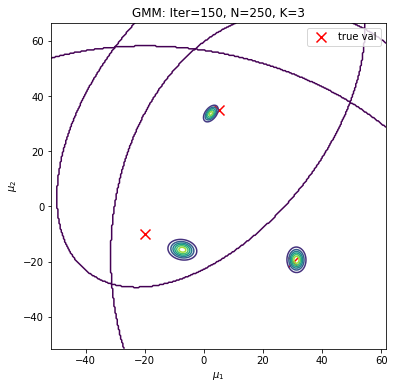

In [33]:
# muの事後分布を作図
plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='true val', 
            color='red', s=100, marker='x') # 真の平均
for k in range(K):
    plt.contour(mu_0_grid, mu_1_grid, posterior_density_kg[k].reshape(mu_dim)) # 事後分布

plt.title('GMM: Iter=' + str(MaxIter) + ', N=' + str(N) + ', K=' + str(K))
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.legend()
plt.show()

In [34]:
# 最後に更新したパラメータの期待値による混合分布を計算
res_density = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(
        x=x_point, mean=m_hat_kd[k], cov=np.linalg.inv(nu_hat_k[k] * w_hat_kdd[k])
    )
    
    # K個の分布の加重平均を計算
    res_density += alpha_hat_k[k] / np.sum(alpha_hat_k) * tmp_density

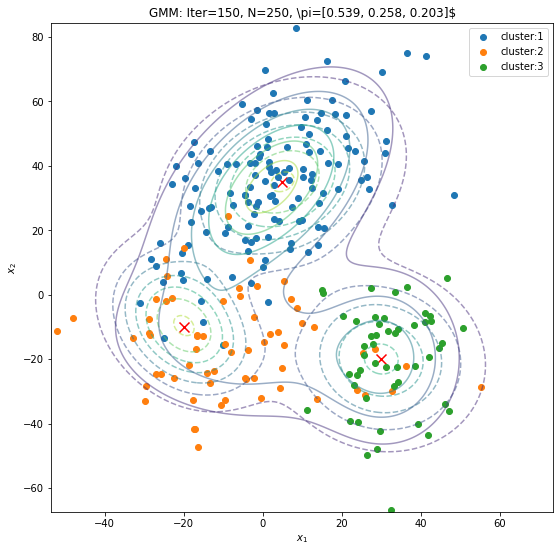

In [35]:
# 最後に更新したパラメータの期待値による分布を作図
plt.figure(figsize=(9, 9))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), alpha=0.5, linestyles='dashed') # 真の分布
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], color='red', s=100, marker='x') # 真の平均
plt.contour(x_1_grid, x_2_grid, res_density.reshape(x_dim), alpha=0.5) # 期待値による分布
for k in range(K):
    k_idx, = np.where(s_n == k) # クラスタkのデータのインデックス
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # サンプルしたクラスタ
#plt.contour(x_1_grid, x_2_grid, res_density.reshape(x_dim)) # 期待値による分布:(等高線)
#plt.colorbar() # 等高線の値:(等高線用)
plt.title('GMM: Iter=' + str(MaxIter) + ', N=' + str(N) + ', \pi=[' + ', '.join([str(pi) for pi in np.round(alpha_hat_k / np.sum(alpha_hat_k), 3)]) + ']$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

## 超パラメータの推移の確認

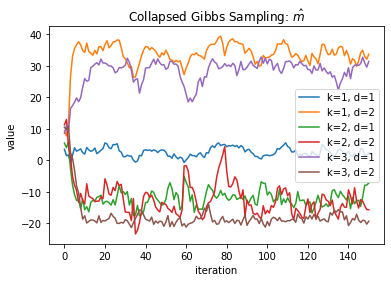

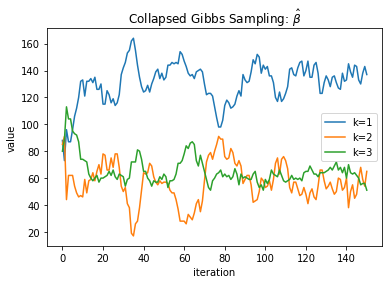

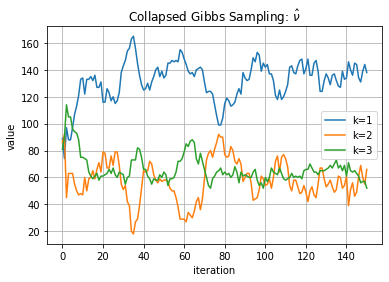

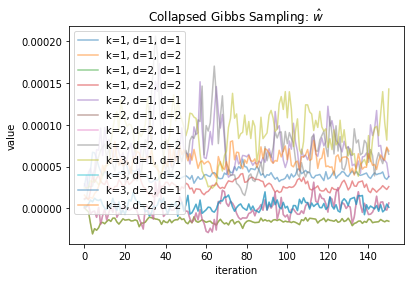

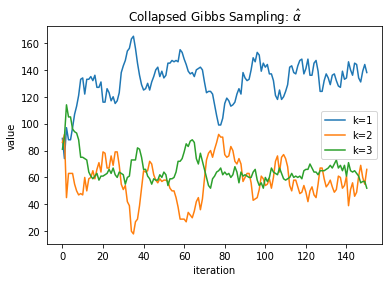

In [36]:
# mの推移を作図
plt.figure()
for k in range(K):
    for d in range(D):
        plt.plot(np.arange(MaxIter+1), np.array(trace_m_ikd)[:, k, d], label='k=' + str(k + 1) + ', d=' + str(d + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Collapsed Gibbs Sampling: $\hat{m}$')
plt.legend() # 凡例
plt.show()

# betaの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_beta_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Collapsed Gibbs Sampling: $\hat{\\beta}$')
plt.legend() # 凡例
plt.show()

# nuの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_nu_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Collapsed Gibbs Sampling: $\hat{\\nu}$')
plt.legend() # 凡例
plt.grid() # グリッド線
plt.show()

# wの推移を作図
plt.figure()
for k in range(K):
    for d1 in range(D):
        for d2 in range(D):
            plt.plot(np.arange(MaxIter + 1), np.array(trace_w_ikdd)[:, k, d1, d2], 
                     alpha=0.5, label='k=' + str(k + 1) + ', d=' + str(d1 + 1) + ', d''=' + str(d2 + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Collapsed Gibbs Sampling: $\hat{w}$')
plt.legend() # 凡例
plt.show()

# alphaの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_alpha_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Collapsed Gibbs Sampling: $\hat{\\alpha}$')
plt.legend() # 凡例
plt.show()